In [3]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up one level to `project` directory

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import wandb
import optuna
from matplotlib.ticker import FuncFormatter
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, accuracy_score, roc_auc_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from data.shots_data_retriever import ShotsDataRetriever
from tqdm import tqdm

In [5]:
shotsDataRetriever = ShotsDataRetriever()
df = shotsDataRetriever.get_df_for_milestone2_part4()

In [6]:
print(df.groupby('is_goal').size())
df

is_goal
0    276763
1     29006
dtype: int64


,game_id,play_num,period,is_goal,x_coord,y_coord,shot_type,is_empty_net,distance,angle_to_goal,game_seconds,last_event_type,last_event_x_coord,last_event_y_coord,time_since_last_event,distance_from_last_event,rebound,angle_change,speed
0,2016020001,7,1,0,77,5,wrist,0,13.928388,21.037511,71,508.0,61.0,11.0,1.0,17.088007,False,0.000000,17.088007
1,2016020001,14,1,0,86,13,wrist,0,13.601471,72.897271,173,504.0,54.0,-5.0,5.0,36.715120,False,0.000000,7.343024
2,2016020001,21,1,0,23,-38,wrist,0,77.025970,-29.560354,241,507.0,72.0,0.0,18.0,62.008064,False,0.000000,3.444892
3,2016020001,23,1,0,33,-15,slap,0,58.940648,-14.743563,286,507.0,77.0,-2.0,19.0,45.880279,False,0.000000,2.414752
4,2016020001,36,1,0,34,28,wrist,0,62.609903,26.565051,406,503.0,47.0,34.0,16.0,14.317821,False,0.000000,0.894864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68485,2019021082,283,3,0,77,-23,backhand,0,26.419690,-60.524111,3405,508.0,72.0,-21.0,21.0,5.385165,False,0.000000,0.256436
68486,2019021082,285,3,0,76,38,slap,0,40.496913,69.775141,3440,503.0,95.0,-17.0,16.0,58.189346,False,0.000000,3.636834
68487,2019021082,286,3,0,79,10,backhand,0,14.866069,42.273689,3442,506.0,76.0,38.0,2.0,28.160256,True,27.501452,14.080128
68488,2019021082,293,3,0,81,-7,snap,0,11.401754,-37.874984,3530,507.0,60.0,40.0,32.0,51.478151,False,0.000000,1.608692


### XGBClassifier v0:
- Trained on `angle_to_goal` and `distance`
- No hyperparameter tuning

In [7]:
X0 = df[['angle_to_goal', 'distance']]
y = df['is_goal']

X_train_0, X_val_0, y_train, y_val = train_test_split(X0, y, test_size=0.3, random_state=42)


In [10]:
model = XGBClassifier()
model.fit(X_train_0, y_train)
y_pred = model.predict(X_val_0)
y_pred_prob = model.predict_proba(X_val_0)[:, 1]
results_v0 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})

wandb.init(
    project="IFT6758.2024-A02",
    name="xgboost-v0",
    config={
        "model": "XGBClassifier",
    }
)

model = XGBClassifier()
model.fit(X_train_0, y_train)

y_pred = model.predict(X_val_0)
y_pred_prob = model.predict_proba(X_val_0)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

wandb.log({
    "accuracy": accuracy,
    "roc_auc": roc_auc,
})

results_v0 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})
wandb.log({"results_v0": wandb.Table(dataframe=results_v0)})

wandb.finish()


accuracy,▁
roc_auc,▁
accuracy,0.90592
roc_auc,0.70851


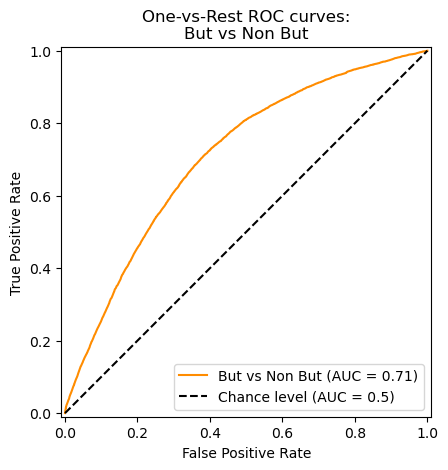

In [10]:
display = RocCurveDisplay.from_predictions(
    results_v0['is_goal'],
    results_v0['goal_proba'],
    name=f"But vs Non But",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nBut vs Non But",
)

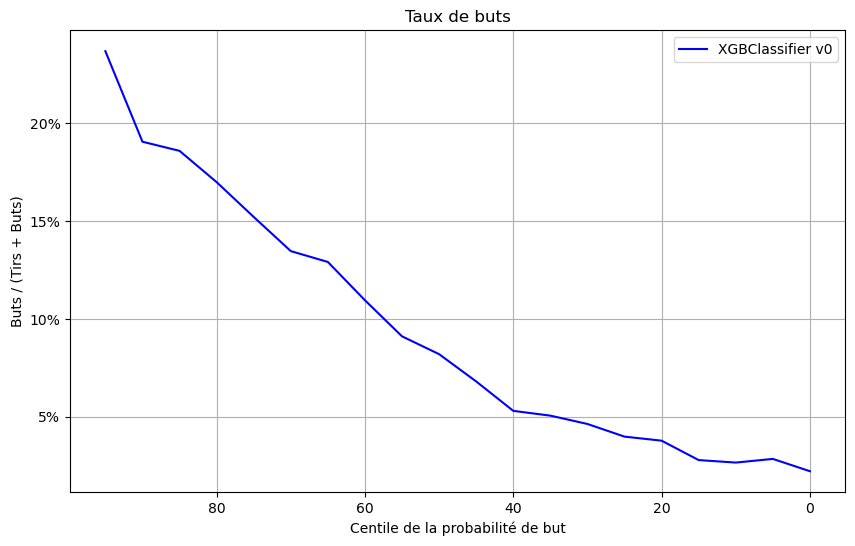

In [14]:
gr_df = results_v0.copy()

percentile_bins = np.linspace(0, 1, 21)
gr_df['percentile'] = pd.qcut(gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goal_rates, color='blue', label='XGBClassifier v0')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

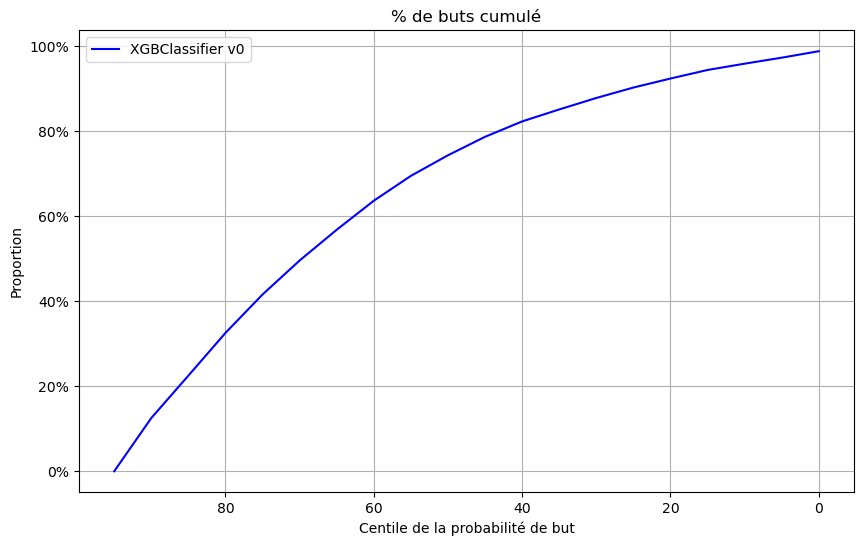

In [17]:
cg_df = results_v0.copy()

percentile_bins = np.linspace(0, 1, 21)
cg_df['percentile'] = pd.qcut(cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
total_shots = cg_df['is_goal'].sum()
goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='XGBClassifier v0')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

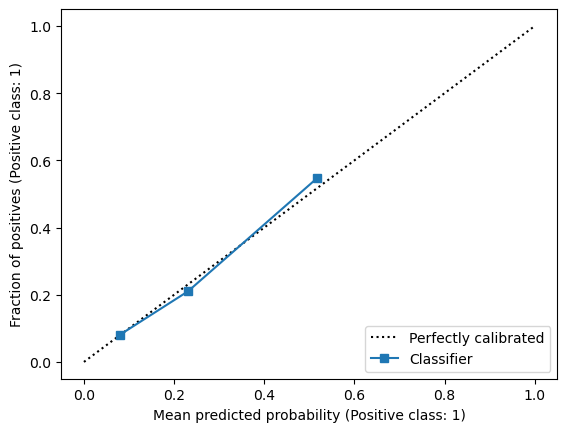

In [18]:
disp = CalibrationDisplay.from_predictions(y_val, results_v0['goal_proba'])
plt.show()

### XGBClassifier v1:
- Trained on all features
- Hyperparameters optimized

In [8]:
df1 = pd.get_dummies(df.drop(columns=['game_id', 'play_num']), columns=['shot_type'])
X1 = df1.drop(columns=['is_goal'])
y = df1['is_goal']

X_train_1, X_val_1, y_train, y_val = train_test_split(X1, y, test_size=0.3, random_state=42)

#### Scoring metric

There is a notable class imbalance in the dataset - 276763 class 0 data points for 29006 class 1 data points. Further - we are not interested in the classifier's ability to correctly label a shot as a goal or not. Instead, we are more focused on creating a classifier able to predict a realistic probability of goal. Given these requirements, I will choose **log-loss** as my scoring metric.

#### Hyperparameter optimization method
I do not have much experience optimizing XGBoost models and so do not have an intuition for which hyperparameter values to explore. Thus, I will **Bayesian Optimization** as it is capable of intelligently exploring different hyperparameter values without requiring them to be set ahead of time.

In [ ]:
wandb.init(
    project="IFT6758.2024-A02",
    name="xgboost-v1",
    config={
        "cv_folds": 3,
        "eval_metric": "logloss",
        "model": "XGBClassifier",
    },
    reinit=True
)

def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    # Initialize the model
    model = XGBClassifier(**params, eval_metric='logloss')
    
    # Perform cross-validation
    score = cross_val_score(model, X_train_1, y_train, scoring='neg_log_loss', cv=3).mean()
    
    # Log trial details to WandB
    wandb.log({
        "trial_number": trial.number,
        "n_estimators": params['n_estimators'],
        "max_depth": params['max_depth'],
        "learning_rate": params['learning_rate'],
        "colsample_bytree": params['colsample_bytree'],
        "subsample": params['subsample'],
        "min_child_weight": params['min_child_weight'],
        "neg_log_loss": score
    })
    
    return score

# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Log best parameters to WandB
wandb.config.update(study.best_params)

# Train the best model
best_xgb_model = XGBClassifier(**study.best_params, eval_metric='logloss')
best_xgb_model.fit(X_train_1, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_val_1)
y_pred_prob = best_xgb_model.predict_proba(X_val_1)[:, 1]

# Log classification report
report = classification_report(y_val, y_pred, output_dict=True)
wandb.log(report)

# Log results DataFrame
results_v1 = pd.DataFrame({
    'goal_proba': y_pred_prob,
    'non_goal_proba': 1 - y_pred_prob,
    'is_goal': y_val
})
wandb.log({"results_v1": wandb.Table(dataframe=results_v1)})

# Print outputs
print("Best parameters:", study.best_params)
print("Classification report:")
print(classification_report(y_val, y_pred))

# Finish the WandB run
wandb.finish()

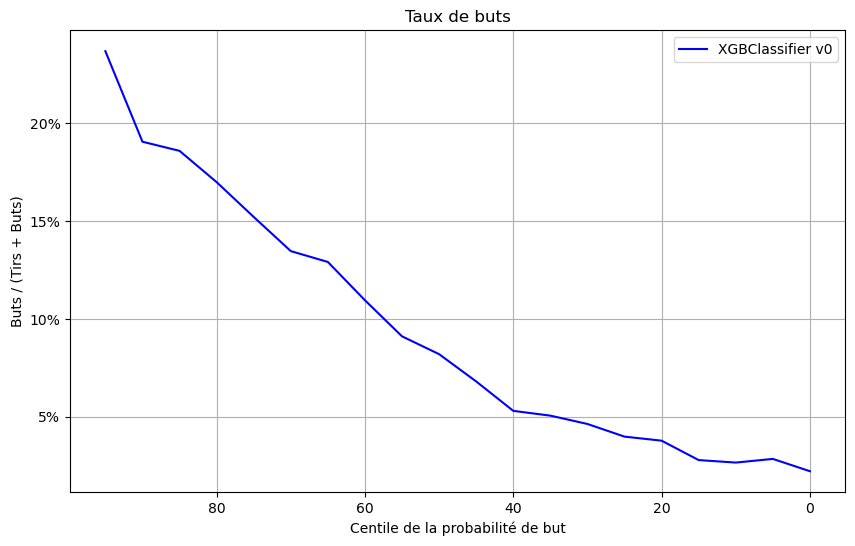

In [ ]:
gr_df = results_v1.copy()

percentile_bins = np.linspace(0, 1, 21)
gr_df['percentile'] = pd.qcut(gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goal_rates, color='blue', label='XGBClassifier v1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid()
plt.show()

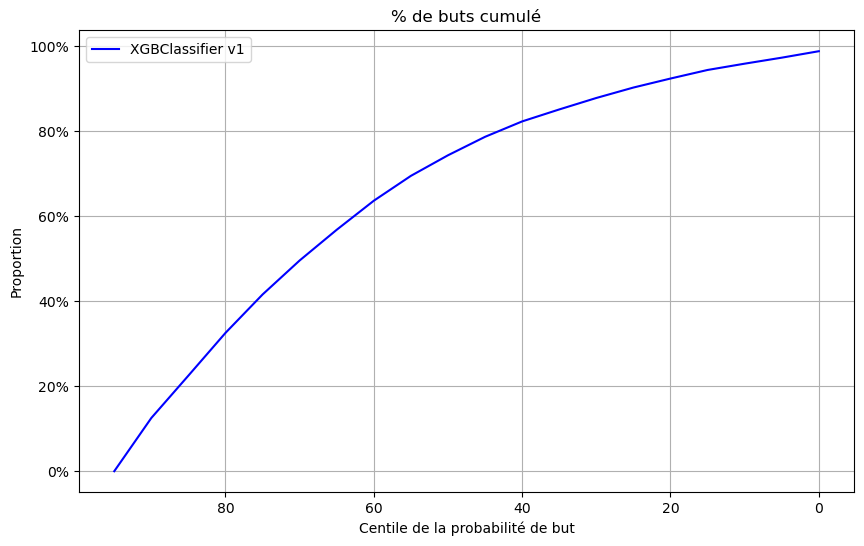

In [25]:
cg_df = results_v1.copy()

percentile_bins = np.linspace(0, 1, 21)
cg_df['percentile'] = pd.qcut(cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]])
total_shots = cg_df['is_goal'].sum()
goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_shots

plt.figure(figsize=(10, 6))
plt.plot(percentile_bins[:-1], goals_cums, color='blue', label='XGBClassifier v1')
plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')
plt.legend()
plt.grid()
plt.show()

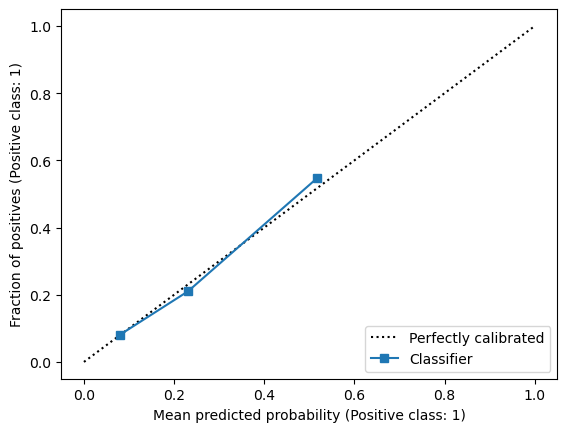

In [26]:
disp = CalibrationDisplay.from_predictions(y_val, results_v1['goal_proba'])
plt.show()

### XGBClassifier v2:
- Trained on select features
- Hyperparameters tuned

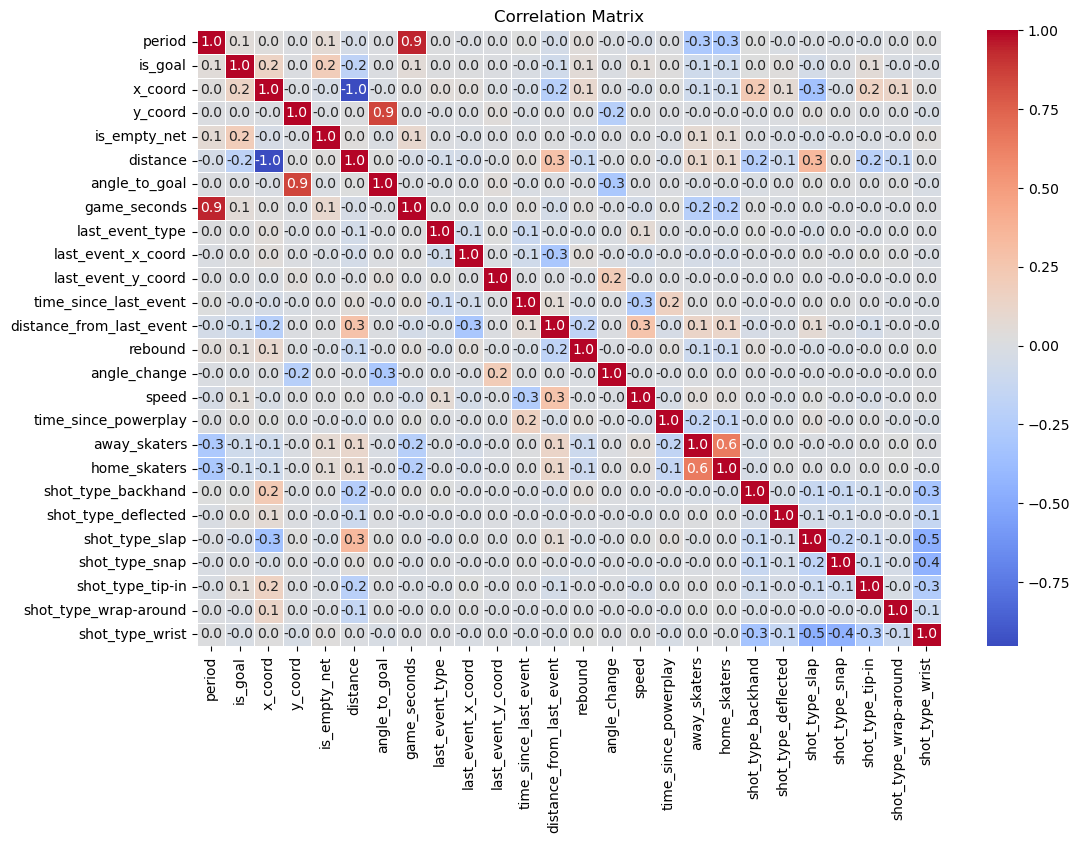

In [33]:
import seaborn as sns

corr_matrix = df1.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [35]:
threshold = 0.9
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

df_reduced = df1.drop(columns=to_drop)
print(f"Dropped columns: {to_drop}")
print(f"Remaining columns: {df_reduced.columns}")

Dropped columns: {'game_seconds', 'distance'}
Remaining columns: Index(['period', 'is_goal', 'x_coord', 'y_coord', 'is_empty_net',
       'angle_to_goal', 'last_event_type', 'last_event_x_coord',
       'last_event_y_coord', 'time_since_last_event',
       'distance_from_last_event', 'rebound', 'angle_change', 'speed',
       'time_since_powerplay', 'away_skaters', 'home_skaters',
       'shot_type_backhand', 'shot_type_deflected', 'shot_type_slap',
       'shot_type_snap', 'shot_type_tip-in', 'shot_type_wrap-around',
       'shot_type_wrist'],
      dtype='object')
